# CSE 152 Intro to Computer Vision Fall 2020 - Assignment 3
### Instructor: Dr. Hao Su
### Assignment Published On: Thursday, November 12th
### Due On: Tuesday, November 24th, 2020 11:59 AM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* All solutions must be written in this notebook
* Programming aspects of this assignment must be completed using Python in this notebook.
* If you want to modify the skeleton code, you can do so. This has been provided just to provide you with a framework for the solution.
* You may use python packages for basic linear algebra (you can use numpy or scipy for basic operations), but you may not use packages that directly solve the problem unless explicitly stated.
* If you are unsure about using a specific package or function, then ask the instructor and teaching assistants for clarification.
* You must submit this notebook exported as a pdf. You must also submit this notebook as .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.


## Problems:

There are 4 Problems in this homework:
* Convolutional Neural Networks [20 pts]
* Adversarial Attacks [6 pts]
* Deep Learning on 3D Data [14 pts]
* Camera Model and Rigid Transformations [30 pts]

# Question 1: Convolutional Neural Networks [20pts]
This question requires you to use the PyTorch framework for neural network training. You will not need a GPU to train the networks for this problem. You will visualize model performance through the use of a confusion matrix and examine the weight matrices used in the networks.

In [53]:
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Conv2d, MaxPool2d, ReLU, Linear, Flatten


In [54]:
train_dataset = MNIST(root='.', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = MNIST('.', train=False, transform=transforms.ToTensor())

## Demo
The following is a code sample for training a simple single-layer perceptron neural network using PyTorch. Running it should give you about 92% testing accuracy.

In [55]:
# Define Single Layer Perceptron network
class SLP(nn.Module):
    def __init__(self, in_features=28*28, classes=10):
        super(SLP, self).__init__()
        # model variables
        self.layer1 = nn.Linear(in_features,classes)
        
    def forward(self, x):
        # linear operation
        x = torch.flatten(x, 1)
        y_pred = self.layer1(x)
        return y_pred

In [56]:
class TrainHelper():
    '''
    Helper class that makes it a bit easier and cleaner to define the training routine
    
    '''
    
    def __init__(self,model,train_set,test_set,opts):
        self.model = model  # neural net
        
        # device agnostic code snippet
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.epochs = opts['epochs']
        self.optimizer = torch.optim.Adam(model.parameters(), opts['lr']) # optimizer method for gradient descent
        self.criterion = torch.nn.CrossEntropyLoss()                      # loss function
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                                        batch_size=opts['batch_size'],
                                                        shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                                       batch_size=opts['batch_size'],
                                                       shuffle=True)
        
    def train(self):
        self.model.train() #put model in training mode
        for epoch in range(self.epochs):
            self.tr_loss = []
            for i, (data,labels) in tqdm_notebook(enumerate(self.train_loader),
                                                   total = len(self.train_loader)):

                data, labels = data.to(self.device),labels.to(self.device)
                self.optimizer.zero_grad()  
                outputs = self.model(data)   
                loss = self.criterion(outputs, labels) 
                loss.backward()                        
                self.optimizer.step()                  
                self.tr_loss.append(loss.item())       
            
            self.test(epoch) # run through the validation set
        
    def test(self,epoch):
            
            self.model.eval()    # puts model in eval mode - not necessary for this demo but good to know
            self.test_loss = []
            self.test_accuracy = []
            
            for i, (data, labels) in enumerate(self.test_loader):
                
                data, labels = data.to(self.device),labels.to(self.device)
                
                # pass data through network
                # turn off gradient calculation to speed up calcs and reduce memory
                with torch.no_grad():
                    outputs = self.model(data)
                
                # make our predictions and update our loss info
                _, predicted = torch.max(outputs.data, 1)
                loss = self.criterion(outputs, labels)
                self.test_loss.append(loss.item())
                self.test_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
            
            print('epoch: {}, train loss: {}, test loss: {}, test accuracy: {}'.format( 
                  epoch+1, np.mean(self.tr_loss), np.mean(self.test_loss), np.mean(self.test_accuracy)))

In [57]:
model2 = SLP()
model2

SLP(
  (layer1): Linear(in_features=784, out_features=10, bias=True)
)

In [58]:
opts = {
    'lr': 5e-4,
    'epochs': 5,
    'batch_size': 64
}

SLPTrainer = TrainHelper(model = model2,
                      train_set = train_dataset,
                      test_set = test_dataset,opts = opts)

In [59]:
SLPTrainer.train()


epoch: 1, train loss: 0.7131417094072553, test loss: 0.402235880304294, test accuracy: 0.8993829617834395



epoch: 2, train loss: 0.37566500392232116, test loss: 0.32780959395466336, test accuracy: 0.9124203821656051



epoch: 3, train loss: 0.32854697368800767, test loss: 0.30449899271794945, test accuracy: 0.9153065286624203



epoch: 4, train loss: 0.3070299430712581, test loss: 0.2919788057352327, test accuracy: 0.9189888535031847



epoch: 5, train loss: 0.29420523351030564, test loss: 0.282760902052852, test accuracy: 0.9205812101910829


## Question 1: Implementing CNN [20 pts]
You will implement a convolutional neural network for the same task as above. Additionally you will analyze the model performance using a confusion matrix and write code to visualize the weight matrices for the first layer of your model.


You may find the PyTorch documentation helpful. https://pytorch.org/docs/stable/nn.html



### 1.1: Implementing CNN [10 pts]
We provide a working network structure below. You can adjust the network size and training options for better performance, but a correct implementation of the provided network should give you the required accuracy. For convolutional layers, (conv MxM, N) means the layer has kernel size $M$ by $M$ and $N$ output channels; for pooling layers, (maxpool MxM) means doing max pooling with kernel size $M$ by $M$.

(conv 5x5, 32) -> (relu) -> (maxpool 2x2) -> (conv 5x5, 64) -> (relu) -> (maxpool 2x2) -> (flatten) -> (linear 10) -> (output)

For full score, you need to achieve 99% testing accuracy. Also, plot the hand-written digits that your network got wrong.

In [60]:
class CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        init convolution and activation layers
        Args:
            input_size: (1,28,28)
            num_classes: 10
        """
        super(CNN, self).__init__() 
        
        ### YOUR CODE HERE
        self.conv_1 = Conv2d(input_size[0], 32, 5)
        self.relu = ReLU()
        self.maxpool = MaxPool2d(2)
        self.conv_2 = Conv2d(32, 64, 5)
        self.flatten = Flatten()
        self.linear = Linear(1024, num_classes) 
        ### END OF CODE
        
    
    def forward(self, x):
        """
        forward function describes how input tensor is transformed to output tensor
        Args:
            x: (Nx1x28x28) tensor
            
        """
        ### YOUR CODE HERE
        
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        ### END OF CODE
        return x

In [61]:
model = CNN((1, 28, 28), 10)
model

### You may (and should) change these
opts = {
    'lr': 1e-3,
    'epochs': 5,   #20,
    'batch_size': 128  #64
}


In [62]:
CNNTrainer = TrainHelper(model = model,
                      train_set = train_dataset,
                      test_set = test_dataset,opts = opts)

In [63]:
CNNTrainer.train()


epoch: 1, train loss: 0.23029152597826935, test loss: 0.07459544015553178, test accuracy: 0.9757713607594937



epoch: 2, train loss: 0.06054350802067246, test loss: 0.03812828733691875, test accuracy: 0.9884295886075949



epoch: 3, train loss: 0.0407991484165001, test loss: 0.0350259258190783, test accuracy: 0.9887262658227848



epoch: 4, train loss: 0.031672423946232334, test loss: 0.02811885778969036, test accuracy: 0.990506329113924



epoch: 5, train loss: 0.02608097008025365, test loss: 0.030837682236422182, test accuracy: 0.9906052215189873


<IPython.core.display.Javascript object>


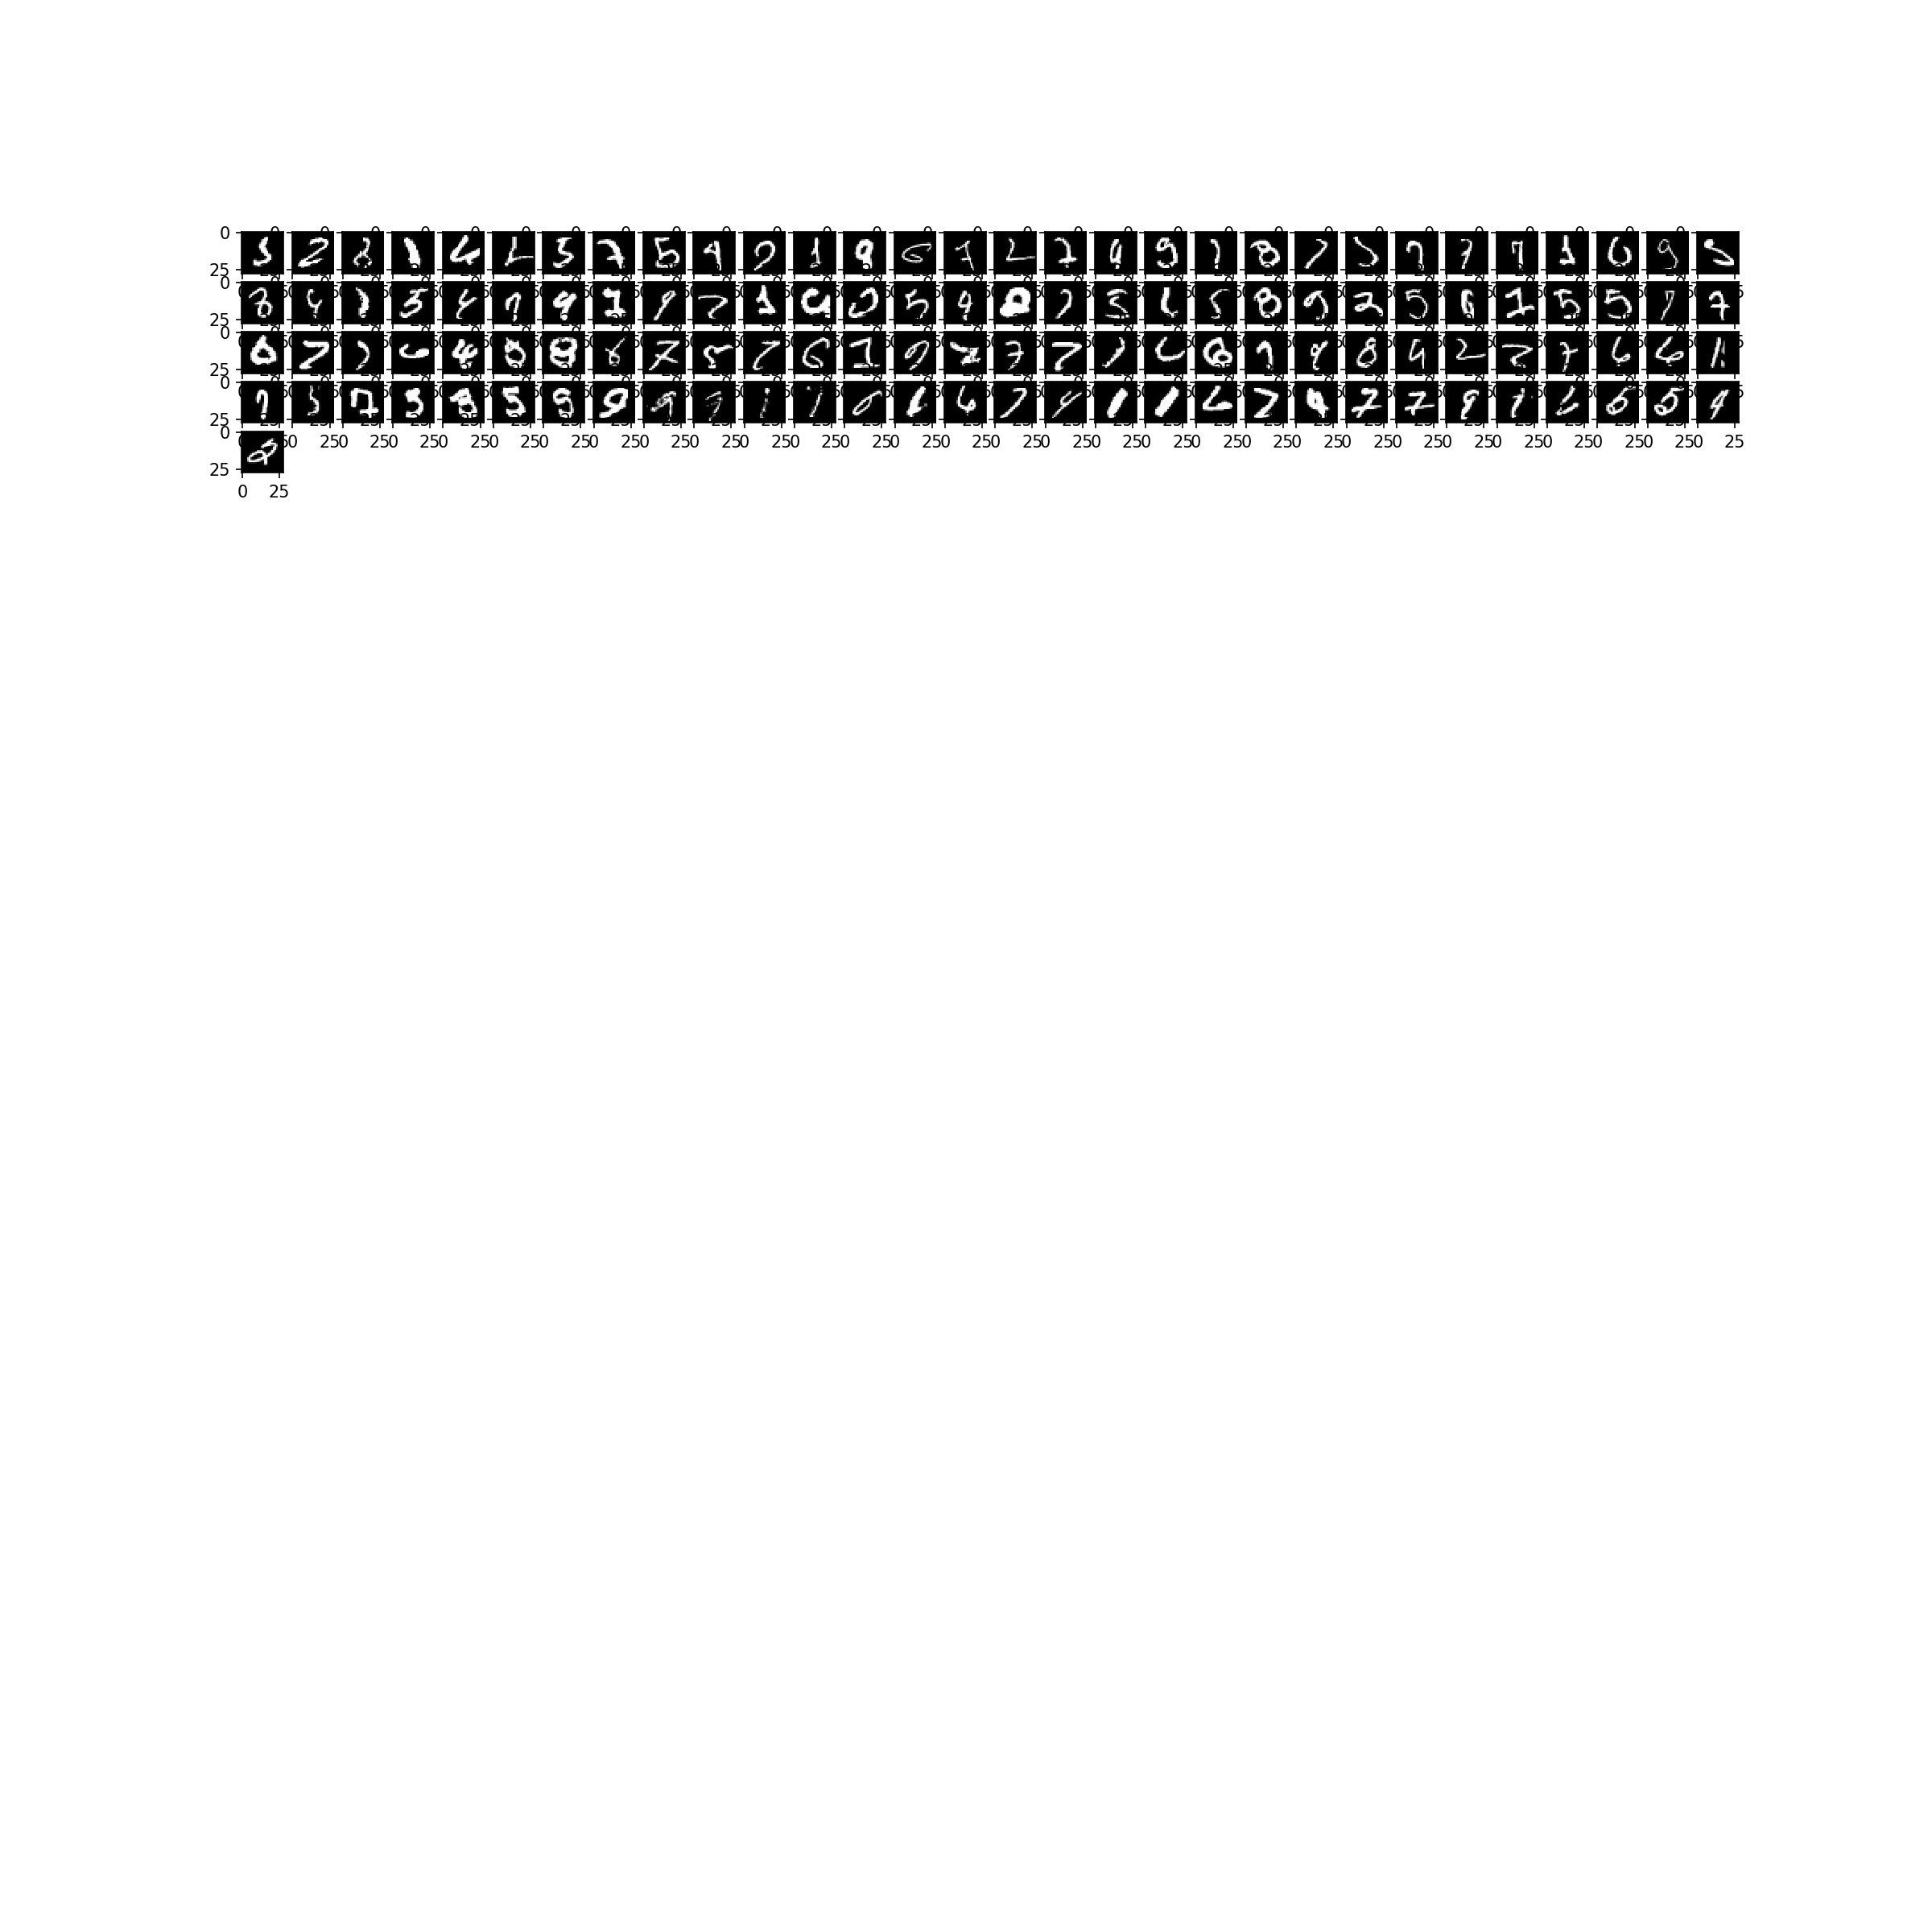

In [64]:
### Write code in this section to plot the digits that the network got wrong ###
test_data = test_dataset.data.unsqueeze(1).float() # N x C x H x W
test_labels = test_dataset.targets

prediction = torch.argmax(model(test_data), dim=1)
fig = plt.figure(figsize=(16, 16))
wL = test_data[test_labels != prediction]
for idx, img in enumerate(wL):
    fig.add_subplot(30, 30, idx + 1)
    plt.imshow(img.squeeze(), cmap='gray')
# also, recommend you use a subplot grid so you don't output an extremely long column of images



### 1.2: Confusion Matrix [5 pts]
Here you will implement a function that computes the confusion matrix for a classifier.
The matrix (M) should be nxn where n is the number of classes.
Entry M[i,j] should contain the fraction of images of class i that were classified as class j.


<IPython.core.display.Javascript object>


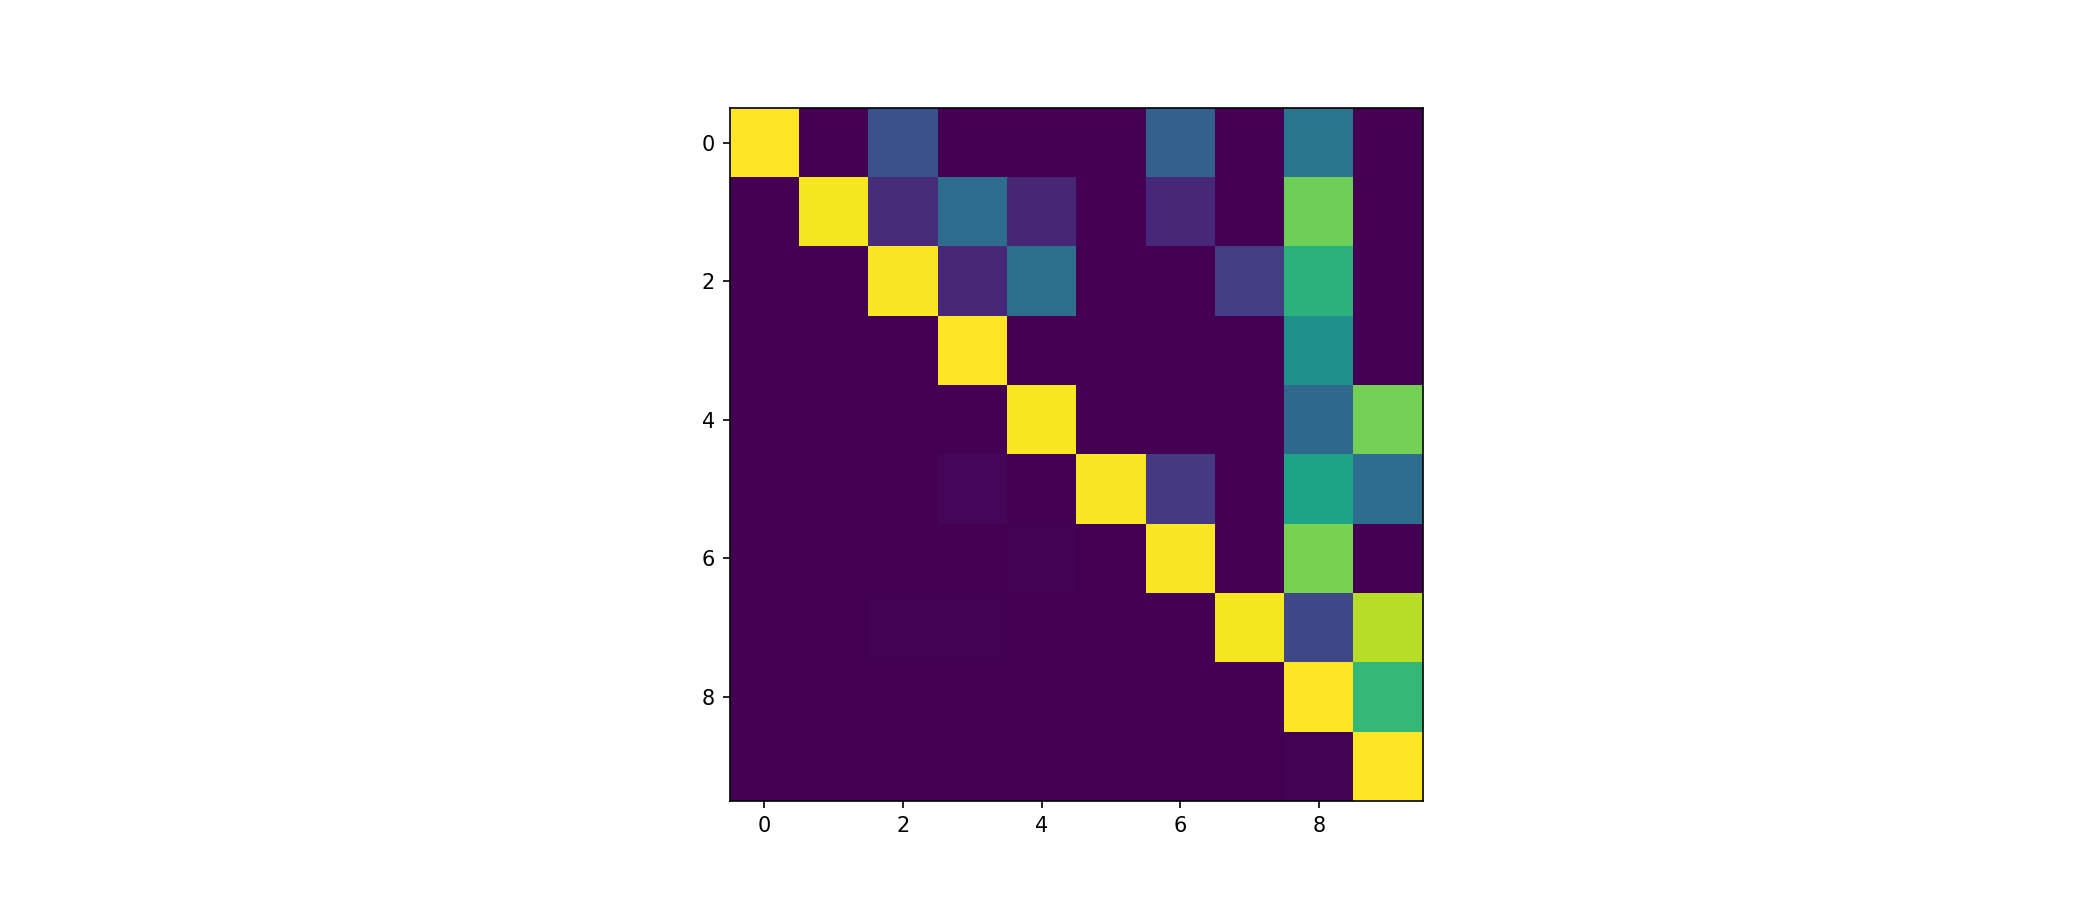

[[1.   0.   0.25 0.   0.   0.   0.31 0.   0.39 0.  ]
 [0.   0.99 0.13 0.35 0.11 0.   0.12 0.   0.78 0.  ]
 [0.   0.   0.99 0.11 0.37 0.   0.   0.18 0.64 0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.5  0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.   0.33 0.79]
 [0.   0.   0.   0.01 0.   0.99 0.17 0.   0.58 0.36]
 [0.   0.   0.   0.   0.01 0.   1.   0.   0.8  0.  ]
 [0.   0.   0.01 0.01 0.   0.   0.   0.99 0.21 0.89]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.67]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


In [65]:
# Using the tqdm module to visualize run time is suggested
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


def confusion(testData, testLabels, classifier):
    M = np.zeros((10,10))
    for i in range(len(test_labels)):
        M[test_labels[i]][prediction[i]] += 1
        
    for i in range(len(M[0])):
          for j in range(len(M)):
                  M[i][j] = (M[i][j])/M[i].sum()
    
        
        
    # you may need to send the data to the device
    # also, if you encounter an error with datatypes and overflow, try using
    # testData.Float() as an input to the confusion function

    return M


def visualize_confusion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)
    plt.show()
    print(np.round(M,2))

M = confusion(test_data, test_labels, model)
visualize_confusion(M)


### 1.3: Weight Visualization [5 pts]

You will plot the weights for the first layer of the Single Layer Perceptron as well as the kernels for your CNN. Comment on what the weights look like and why that may be so. 


#### 1.3.1: Single Layer Perceptron Weights: [2 pts]

The simple linear classifier already performs quite well. Plot the filter weights corresponding to each output class (weights, not biases) as images. (Normalize weights to lie between 0 and 1 and use color maps like 'inferno' or 'plasma' for good results).

hint: You might need to look at PyTorch documentation (or play with the PyTorch model) to figure out how to get the weights.

<IPython.core.display.Javascript object>


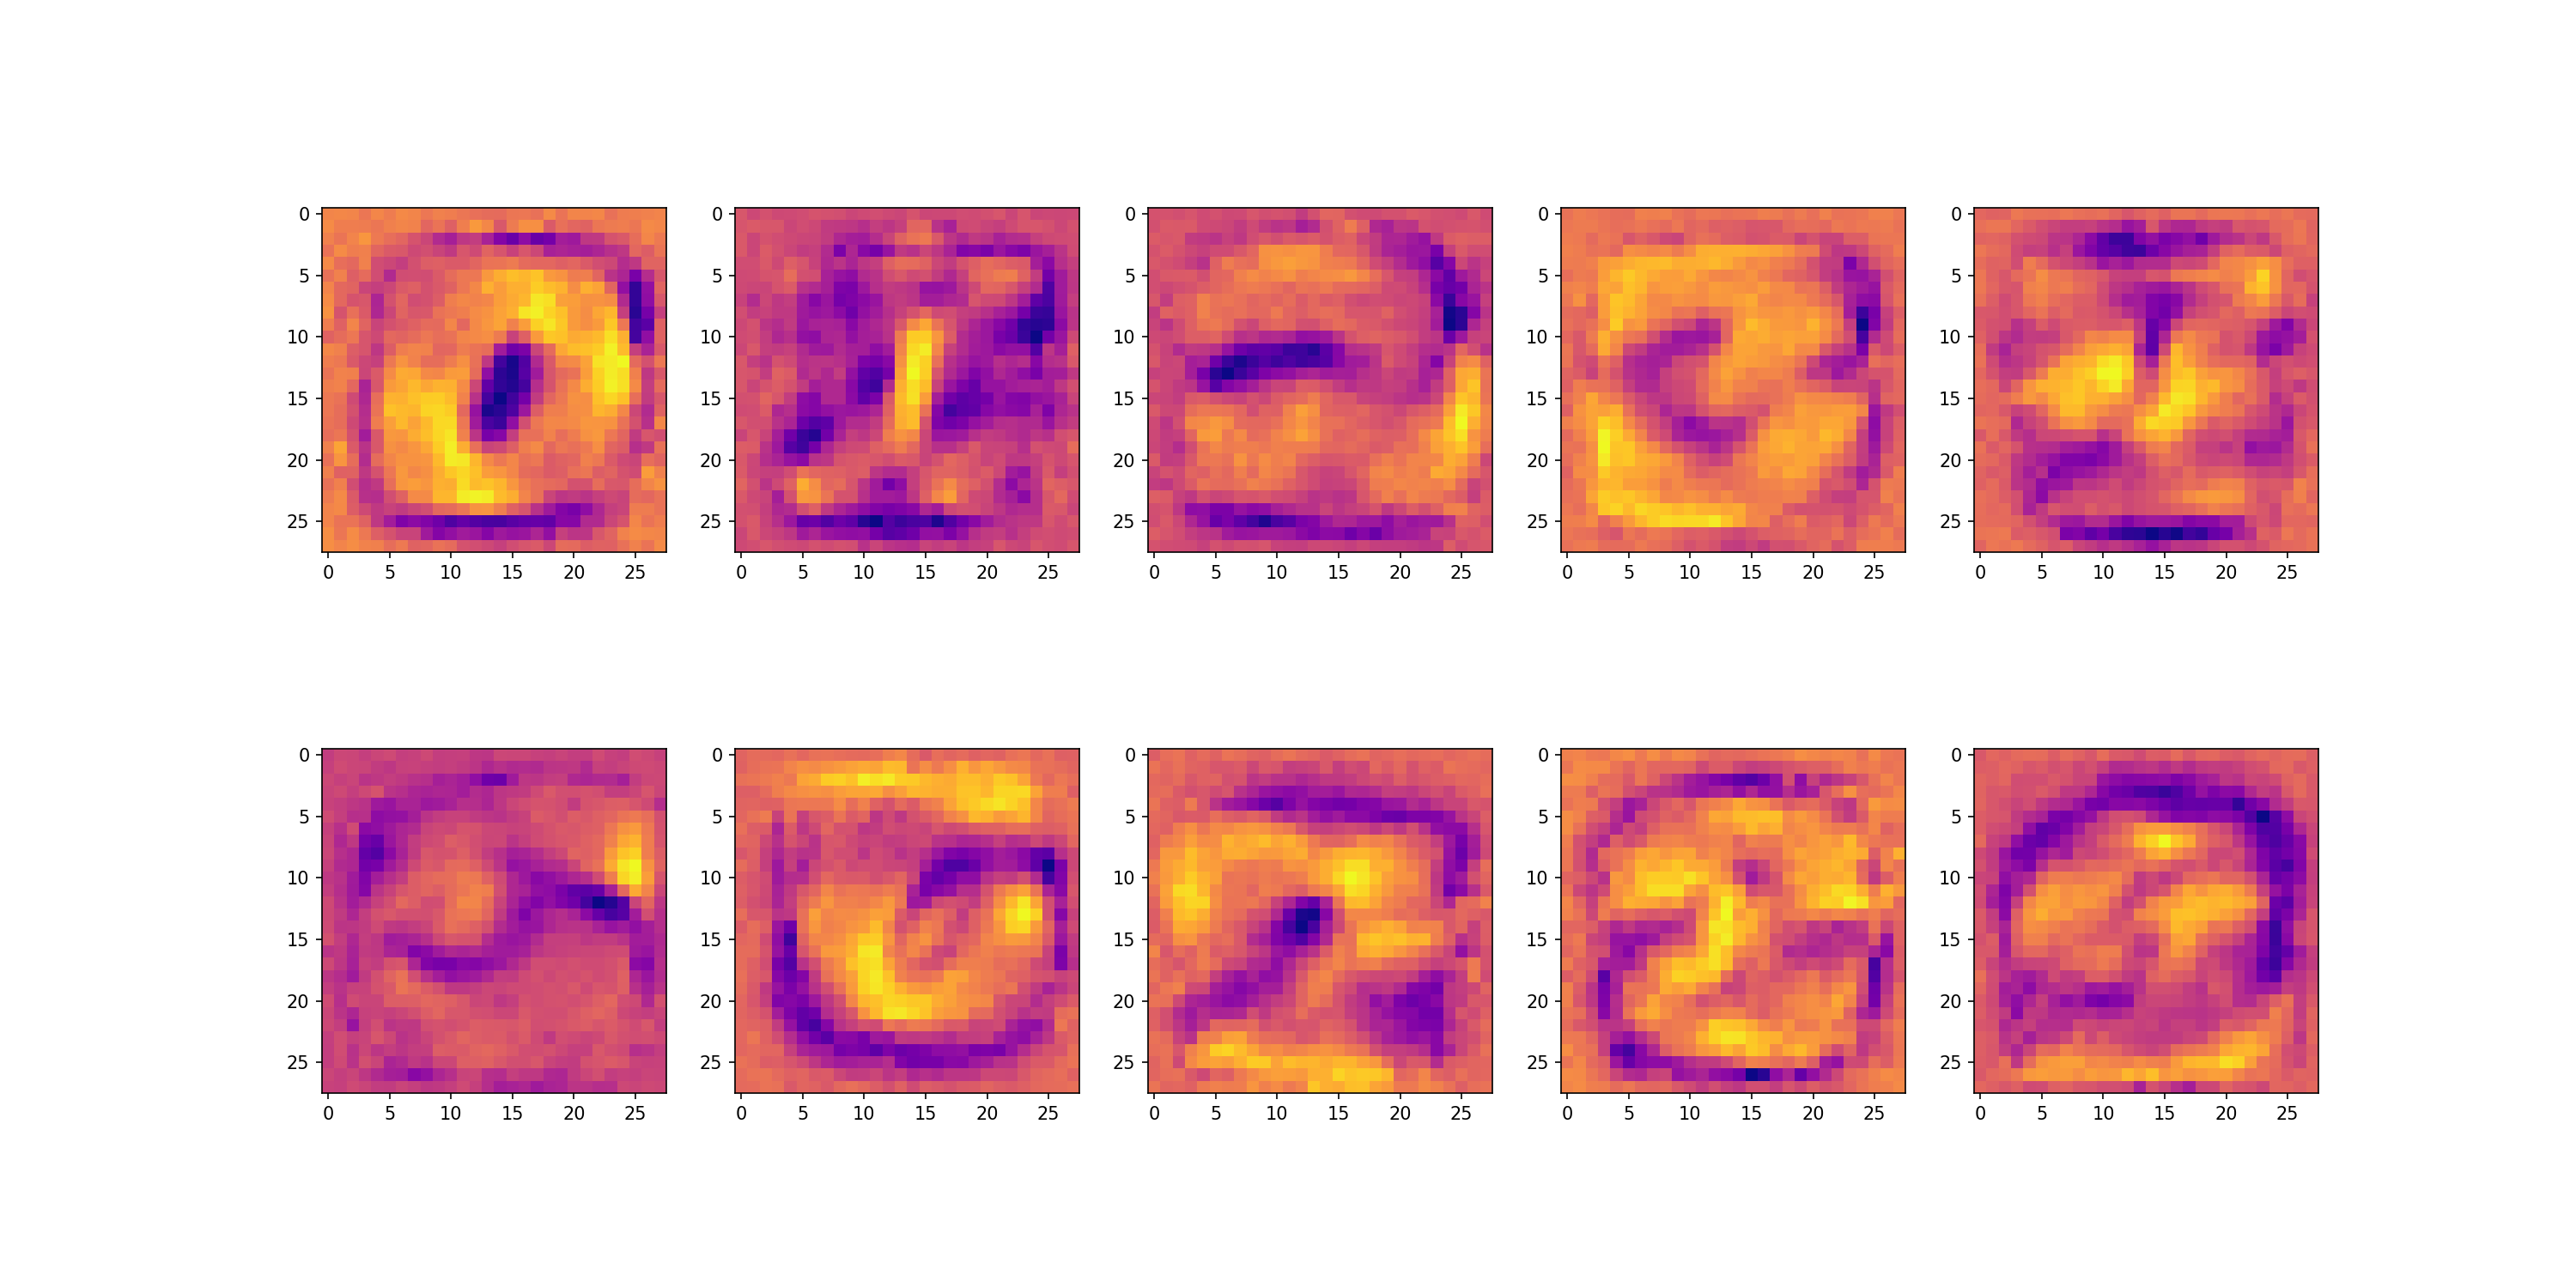

In [66]:
# SLP plot filter weights
import sklearn

    

weights = sklearn.preprocessing.normalize(model2.layer1.weight.data.numpy())
plt.figure(figsize = (20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(weights[i].reshape(28, 28),cmap = 'plasma')
    

#### Comment: 

<IPython.core.display.Javascript object>


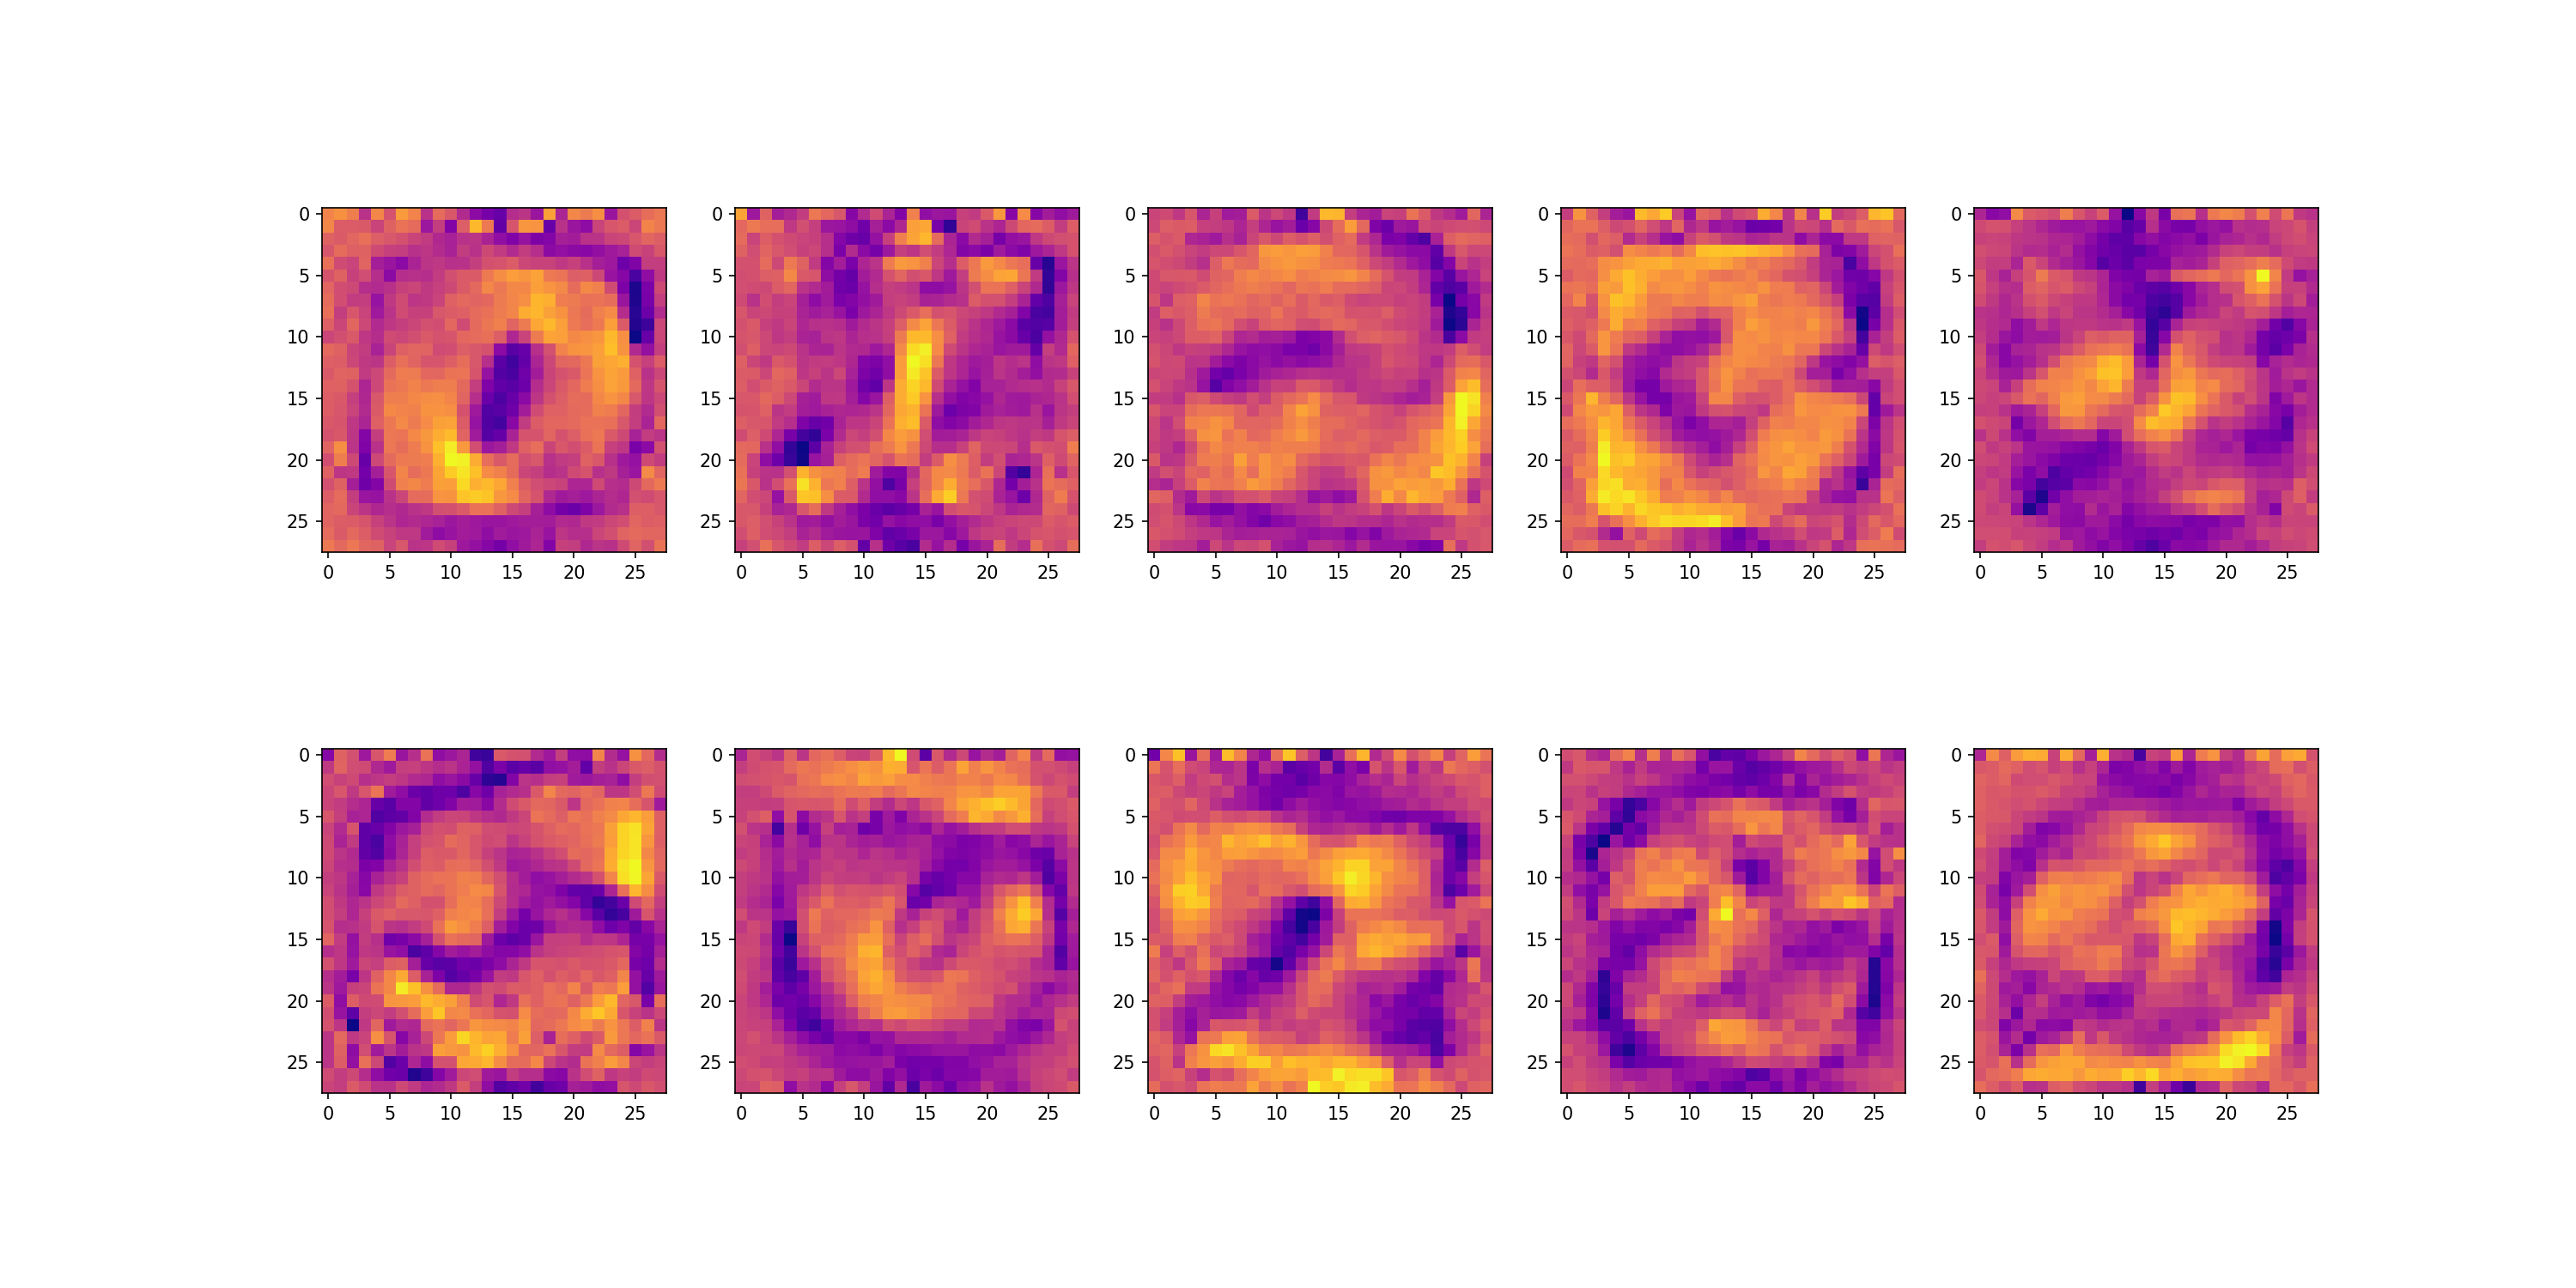

In [67]:
plt.figure(figsize = (20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(sklearn.preprocessing.normalize(model2.layer1.weight.data.numpy()[i].reshape((28,28))),cmap = 'plasma')

#### 1.3.2: CNN Weights: [3 pts]
For this question, you need to visualize the kernel weights for your first convolutional layer. Suppose you have 5x5 kernels with 32 output channels. You will plot 32 5x5 images. 



<IPython.core.display.Javascript object>


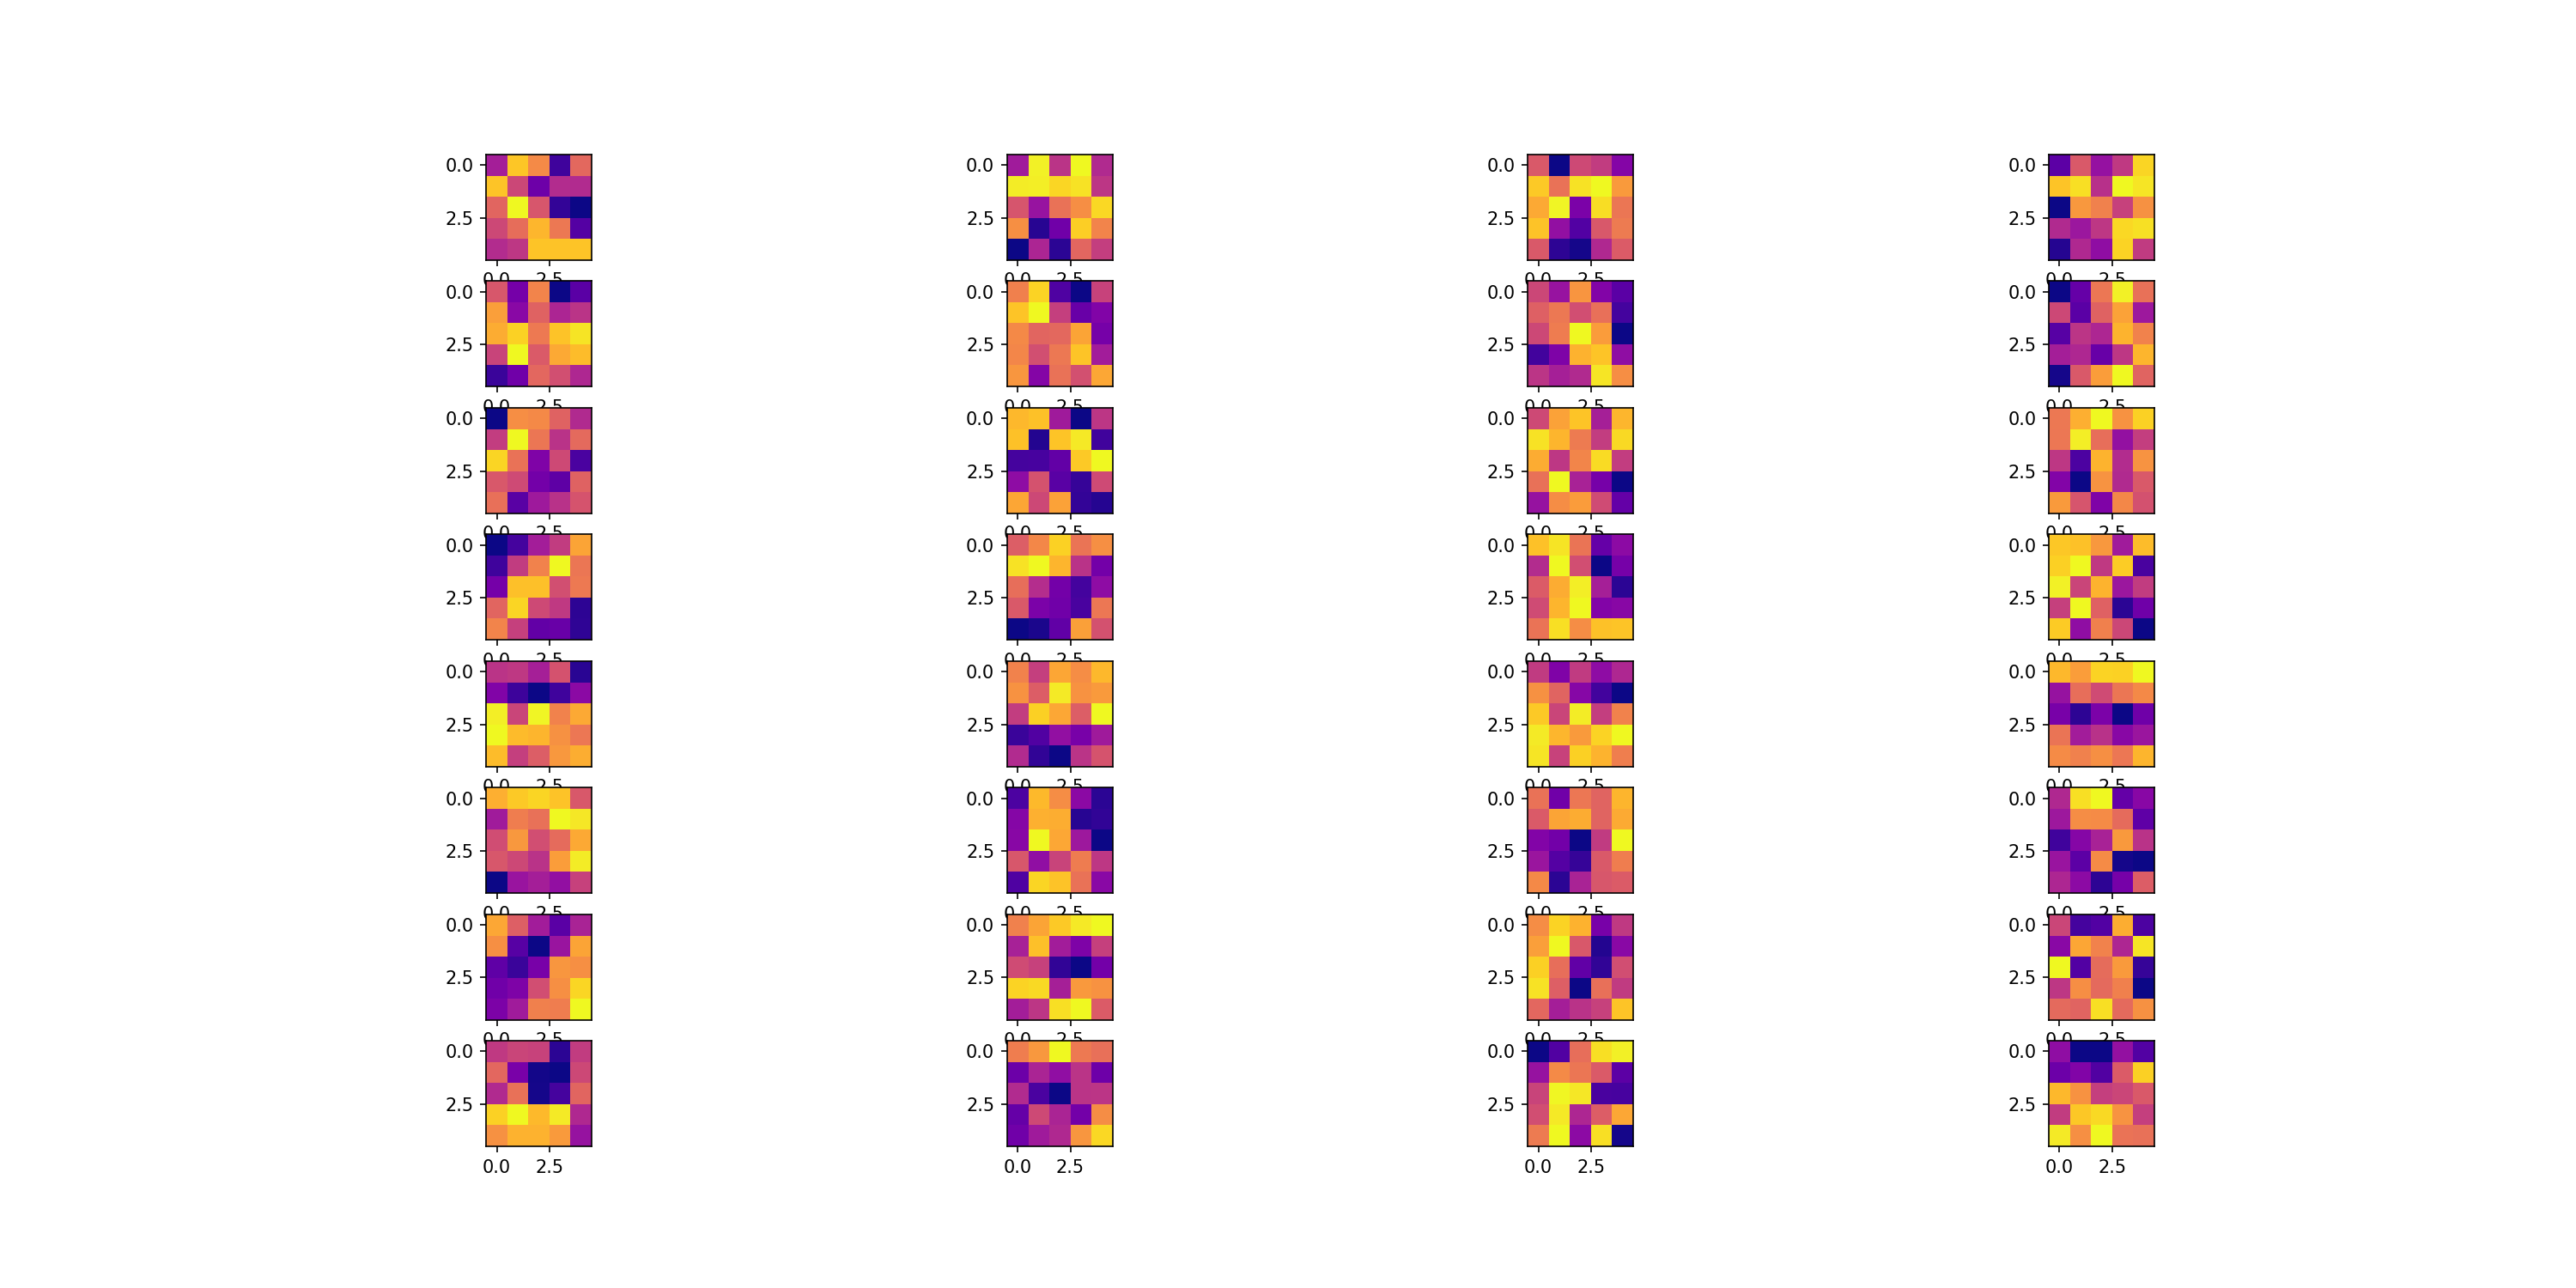

In [68]:
# CNN plot filter weights
fig = plt.figure(figsize=(20, 10))
x = model.conv_1.weight.detach().numpy()
for i, kernel in enumerate(x):
    fig.add_subplot(8, 4, i + 1)
    plt.imshow(kernel.squeeze(), cmap='plasma')


#### Comment: 



## Question 2: Adversarial Attacks [6 pts]

Using the CNN you trained in the previous section, you will examine the how adversarial noise affects the classification accuracy of the network as it is exposed to different magnitudes of adversarial noise. 

#### 2.1 Fast Sign Gradient Method [4 pts]

Write a function 'perturb_image' that generates adversarial noise using the fast sign gradient method, and subsequently adds that noise to the input image 

In [69]:
def perturb_image(image, epsilon, data_grad):
    
    '''
    Add code here to generate noise using the fast sign gradient method
    
    '''
    image.requires_grad = True
    model.zero_grad()
    perturbed_image = image + epsilon *image.grad.sign()
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [70]:
def eval_adversarial(TrainerObject, device, epsilon ):
    
    '''
    
    - routine to examine the effect of adversarial noise at various epsilon magnitudes
    - nothing needs to be added to this code
    
    '''

    # Accuracy counter
    correct = 0
    adv_examples = []
    # Loop over all examples in test set
    for i, (data, label) in enumerate(TrainerObject.test_loader):
        
        data, label = data.to(device), label.to(device)
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        model.zero_grad()
        output = TrainerObject.model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != label.item():
            continue

        # Calculate the loss
        loss = TrainerObject.criterion(output, label)
        loss.backward()

        # collect the gradient data about the network inputs
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = perturb_image(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = TrainerObject.model(perturbed_data)

        
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == label.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(TrainerObject.test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(TrainerObject.test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

Plot the Classifier Accuracy as a function of epsilon:

In [71]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
# put model in eval mode
CNNTrainer.model.eval()

# update the helper class with a new batch size = 1
# for the dataloader. It doesnt change the model 
# weights or any other parameter 

opts = {
    'lr': 5e-4,
    'epochs': 5,
    'batch_size': 1 #this is the only change
}

CNNTrainer = TrainHelper(model = CNNTrainer.model,
                      train_set = train_dataset,
                      test_set = test_dataset,opts = opts)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Run test for each epsilon
for eps in epsilons:
    acc, ex = eval_adversarial(CNNTrainer, device, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9905 / 10000 = 0.9905
Epsilon: 0.05	Test Accuracy = 9476 / 10000 = 0.9476
Epsilon: 0.1	Test Accuracy = 8012 / 10000 = 0.8012
Epsilon: 0.15	Test Accuracy = 5140 / 10000 = 0.514
Epsilon: 0.2	Test Accuracy = 2173 / 10000 = 0.2173
Epsilon: 0.25	Test Accuracy = 871 / 10000 = 0.0871
Epsilon: 0.3	Test Accuracy = 460 / 10000 = 0.046


View the visual effect of various magnitudes of Epsilon

<IPython.core.display.Javascript object>


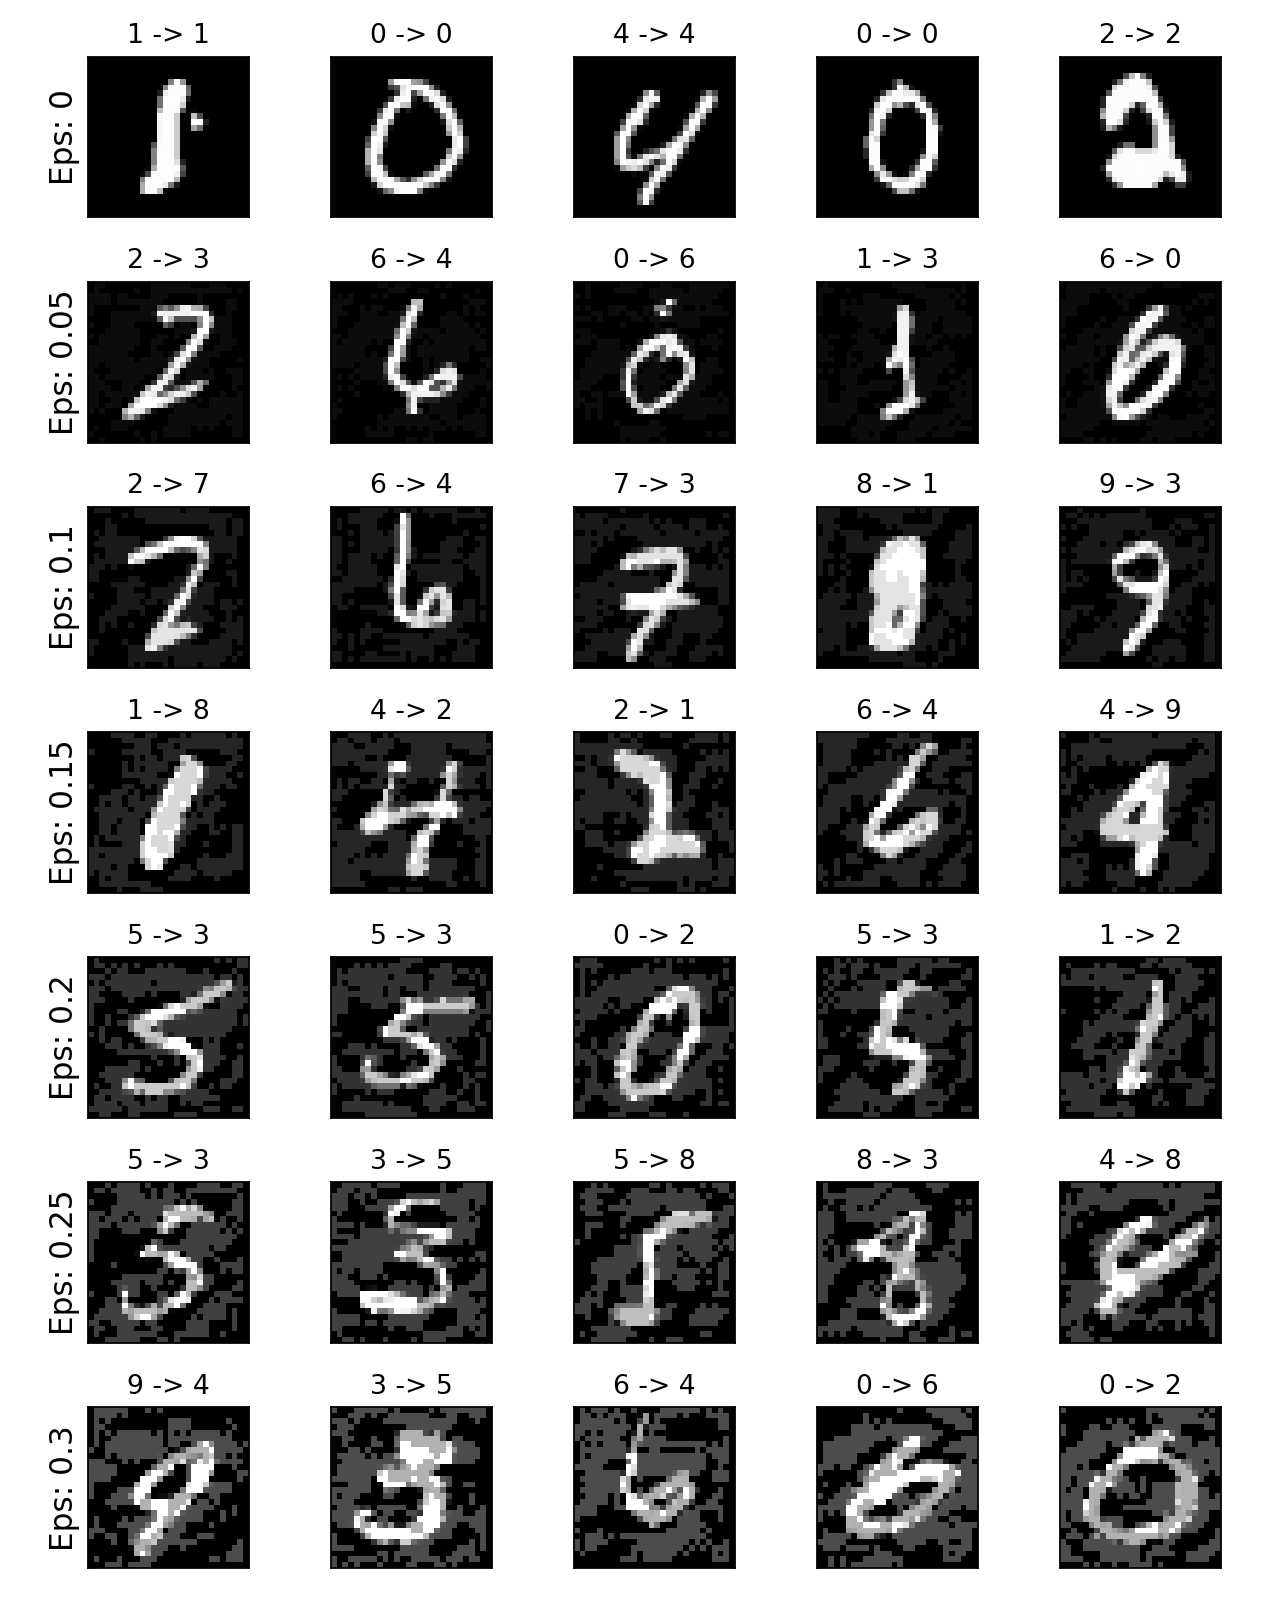

In [72]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### 2.2 Commentary: [2 pts]
What epsilon value would you choose if you wanted to cause a high degree of misclassification without alerting human observers? Explain your answer. 

#### Analysis: 


# Question 3: Deep Learning on 3D Data [14 pts]

For this problem you will implement a PointNet Architecture without the Transfomer sub-networks. The architecture will look similar to the image below. In addition to training the network you will write code to retain and visualize the salient points. There are five object classes with 100 samples of each class in the dataset. The classes are: chair, car, lamp, airplane, and table.

![Sample Plots](PointNet_Image.png)

In [189]:
from ShapeNetDataset import ShapeNetDataset
from mpl_toolkits.mplot3d import Axes3D

In [190]:
pc_data = ShapeNetDataset(root = 'PointNet_Dataset',npoints = 500)
train_dataset, test_dataset = torch.utils.data.random_split(pc_data, [450, 50])

Visualizing a sample datapoint

Text(0.5, 0, 'Z')

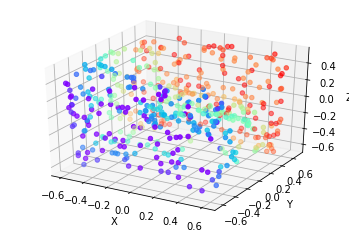

In [383]:
%matplotlib notebook
%matplotlib inline
x = train_dataset[100][0].numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
c = (x[:,2])
ax.scatter(x[:,0],x[:,2],x[:,1],zdir='z',c = c,cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

## PointNet Architecture [7 pts]

Build a pointnet architecture similar to the example described above. The model should reach at least 90% accuracy on the test set. 

In [345]:
class PointNet(nn.Module):
    def __init__(self,classes=5):
        super().__init__()
 
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,200,1)
   
    
        self.fc1 = nn.Linear(200,128)
        self.fc2 = nn.Linear(128,5)
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):

        x = torch.transpose(x,1,2)
        xb = F.relu(self.conv1(x))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        xb = nn.Flatten(1)(xb)
        xb = F.relu(self.fc1(xb))
        xb = self.fc2(xb)
    
     
        return xb

In [346]:
# call the model
PtNet = PointNet()
opts = {
    'lr': 1e-3,
    'epochs': 20,
    'batch_size': 32
}
# call the trainer class

PtNetTrainer = TrainHelper(model = PtNet,
                      train_set = train_dataset,
                      test_set = test_dataset,
                           opts = opts)


In [347]:
PtNetTrainer.train()


epoch: 1, train loss: 1.5847554206848145, test loss: 1.5625560879707336, test accuracy: 0.3663194444444444



epoch: 2, train loss: 1.482916037241618, test loss: 1.3886649012565613, test accuracy: 0.2986111111111111



epoch: 3, train loss: 1.182936962445577, test loss: 0.9902893900871277, test accuracy: 0.7569444444444444



epoch: 4, train loss: 0.8143507798512777, test loss: 0.6345198452472687, test accuracy: 0.8038194444444444



epoch: 5, train loss: 0.5302625854810079, test loss: 0.38744181394577026, test accuracy: 0.953125



epoch: 6, train loss: 0.4209542632102966, test loss: 0.3450331389904022, test accuracy: 0.9409722222222222



epoch: 7, train loss: 0.3052393758359055, test loss: 0.2747352570295334, test accuracy: 0.9253472222222222



epoch: 8, train loss: 0.2620440368851026, test loss: 0.2709186524152756, test accuracy: 0.9131944444444444



epoch: 9, train loss: 0.2244371364514033, test loss: 0.2485368698835373, test accuracy: 0.9409722222222222



epoch: 10, train loss: 0.2472717265288035, test loss: 0.24928086251020432, test accuracy: 0.9131944444444444



epoch: 11, train loss: 0.24956773010392982, test loss: 0.19237224012613297, test accuracy: 0.9409722222222222



epoch: 12, train loss: 0.1694374978542328, test loss: 0.22177588939666748, test accuracy: 0.9166666666666667



epoch: 13, train loss: 0.13993256414930025, test loss: 0.17963023483753204, test accuracy: 0.9409722222222222



epoch: 14, train loss: 0.14257531488935152, test loss: 0.18694809079170227, test accuracy: 0.9253472222222222



epoch: 15, train loss: 0.12748168930411338, test loss: 0.17627911269664764, test accuracy: 0.9409722222222222



epoch: 16, train loss: 0.1309541840106249, test loss: 0.20999539643526077, test accuracy: 0.9288194444444444



epoch: 17, train loss: 0.1145827313264211, test loss: 0.2703280635178089, test accuracy: 0.8854166666666667



epoch: 18, train loss: 0.1128186294498543, test loss: 0.18516892939805984, test accuracy: 0.9253472222222222



epoch: 19, train loss: 0.11563842611697812, test loss: 0.1959816813468933, test accuracy: 0.9097222222222222



epoch: 20, train loss: 0.1040443204343319, test loss: 0.1846955493092537, test accuracy: 0.9131944444444444


## Critical Point Visualization [7 pts]

The function below identifies and returns critical point information for 5 samples, 1 sample in each class. Finish the code in the function and plot the critical points with the helper function below. Critical points are defined as points that have a gradient greater than zero with respect to the loss function. 


In [441]:
def grab_critical(model,data):
    
    
    '''
    
    The starter code template pulls one example from each class and stores the data in the dictionary
    indexed by class. The dictionary should store the indices of the top critical points and
    also store the entire numpy array of the point cloud. It will be used in the subsequent plotting function.
    
    '''
    
    model = model.eval()
    data_loader = torch.utils.data.DataLoader(dataset=data,
                                              batch_size=1,
                                              shuffle=True)
    
    crit_point_dict = {}
    label_indices = [0,1,2,3,4]
    loss_criterion = torch.nn.CrossEntropyLoss() # this allows you to not need the TrainHelper Class
    
    for i, (data, labels) in enumerate(data_loader):
        if labels.numpy() in label_indices:
            # create index in the dictionary and remove the class id from the list of indices
            # we are looking for
            class_label = labels.numpy()[0]
            label_indices.remove(class_label)
            crit_point_dict[class_label] = {}
            crit_point_dict[class_label]['indices'] = []
            crit_point_dict[class_label]['data'] = []
            
            # run sample through the network

            
            data.requires_grad = True
            output = model(data)
            loss = loss_criterion(output, labels)
            loss.backward()
         
            gradient = data.grad.data
            gradient = torch.squeeze(gradient, 0)
            data.reshape(500,3)
            crit_point_dict[class_label]['data']    = data.detach().numpy()
            
            ind = []
            for i, x in enumerate(gradient):
                for item in x:
                    if item > 0:
                        ind.append(i)
                        break
                        
            for y in ind:
                   crit_point_dict[class_label]['indices'].append(y)
     
    
    return crit_point_dict
            
            

Visualizing the Critical Points: use the code provided to visualize the critical points

In [442]:
%matplotlib inline

'''
update the variables with the proper variable names

'''
data = test_dataset
model = PtNet
c_points = grab_critical(model,data)

for i in range(5):
    data = c_points[i]['data']
    data_crit = data[c_points[i]['indices'][:],:]
    fig = plt.figure(figsize = (15,5))
    ax = fig.add_subplot(121, projection='3d')
    c = (data_crit[:,2])
    ax.scatter(data_crit[:,0],data_crit[:,2],data_crit[:,1],c = c,cmap=plt.get_cmap('rainbow'))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Critical Points')
    ax = fig.add_subplot(122, projection='3d')
    c = (c_points[i]['data'][:,2])
    ax.scatter(c_points[i]['data'][:,0],c_points[i]['data'][:,2],c_points[i]['data'][:,1],\
               c = c,cmap=plt.get_cmap('rainbow'))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Original Points')
    


IndexError: index 6 is out of bounds for axis 0 with size 1

## Question 4: Camera Model and Rigid Transforms [30 pts]



### 4.1.1: Planar Projection  [7 pts]

Consider a perspective projection where a point 

$$
P = \begin{bmatrix} x\\y\\z \end{bmatrix}
$$

is projected onto an image plane $\Pi'$ represented by $k = f'>0$ as shown in the following figure.
![title](fig1.png)

The first second and third coordinate axes are denoted by $i$, $j$, $k$ respectively. 

Consider the location of points Q1 and Q2 in the world coordinate system. The locations are parameterized by the equations below:

$$
Q1 = [\text{-2, 3,-5}] + t[\text{3 6 10}]
$$
$$
Q2 = [\text{ 3,-4,-2}] + t[\text{3 6 10}]
$$
where $ t \leq -1$. 

Calculate the projection of points Q1 and Q2 onto the image plane when $ t = -1$, and the limit as t approaches $-\infty $. Identify the vanishing points of Q1 and Q2.



#### Answer:


### 4.1.2: Vanishing Point [3 pts]

Explain why two lines that are parallel have the same vanishing point:

Suppose we have camera center (X,Y,Z) = (0,0,0) that does not lie on the line and say we have point (X1,Y1,Z1) in space with direction (Tx,Ty,Tz), then the camera center and the line form a plane.
As distance t → ∞, we go to a point at infinity in direction (Tx, Ty) in the image plane. Thus, if we havea set of parallel lines whose direction is perpendicular to the Z axis, then the vanishing point is a point at infinity in the direction of the lines.
Notice that the vanishing point is only defined by the direction vector (TX, TY , TZ), not by thepoint (X1, Y1, Z1). This means that we can vary the latter point however we like and we will always get the same vanishing point. Thus, any set of parallel lines have the same
vanishing point.


## 4.2: Image Projection and Rigid Transformations [20 points]


In  this  problem  we  will  practice  rigid  body  transformations  and  image  formations  through  the pinhole perspective camera model. The goal will be to photograph the following four points 
$$^AP_1 = [\text{-1 -0.5 2}]^T$$,  $$^AP_2 = [\text{1 -0.5 2}]^T$$, $$^AP_3 = [\text{1 0.5 2}]^T$$, $$^AP_4 = [\text{-1 0.5 2}]^T$$

To do this we will need two matrices.  Recall, first, the following formula for rigid body transformation
$$
^BP = \text{ } ^B_AR\text{ }^AP + \text{ } ^BO_A
$$

Where $^BP$ is the point coordinate in the target ($B$) coordinate system. $^AP$ is the point coordinate in the source ($A$) coordinate system. $^B_AR$ is the rotation matrix from $A$ to $B$, and $^BO_A$ is the origin of the coordinate system $A$ expressed in $B$ coordinates. 

The rotation and translation can be combined into a single 4 $\times$ 4 extrinsic parameter matrix, $P_e$, so that $^BP = P_e \text{ }^AP$ where $^AP$ and $^BP$ are in homogeneous coordinates.

Once transformed, the points can be photographed using the intrinsic camera matrix, $P_i$ which is a 3 $\times$ 4 matrix.

Once these are found, the image of a point, $^BP$, can be calculated as $P_i P_e \text{ }^AP$.

We will consider four different settings of focal length, viewing angles and camera positions below. For each of these calculate:

    a) Extrinsic transformation matrix

    b) Intrinsic camera matrix under the perspective camera assumption

    c) Calculate the image of the four vertices and plot using the supplied functions

    Your output should look something like the following image (Your output values might not match, this is just an example)



![Sample Plots](example.png)

We will not use a full intrinsic camera matrix (e.g.  that maps centimeters to pixels, and defines  the  coordinates  of  the  center  of  the  image),  but  only  parameterize  this  with $f$,  the  focal
length.  In other words:  the only parameter in the intrinsic camera matrix under the perspective assumption is $f$.

1. [No rigid body transformation]. Focal  length  =  1. The  optical  axis  of  the  camera  is aligned with the z-axis.
2. [Translation]. $^BO_A = [\text{0 0 1}]^T$. Focal length = 1. The optical axis of the camera is aligned with the z-axis.
3. [Translation and Rotation]. Focal length = 1. $^B_AR$ encodes a 30 degrees around the z-axis and then 60 degrees around the y-axis. $^BO_A = [\text{0 0 1}]^T$.
4. [Translation and Rotation, long distance]. Focal length = 5. $^B_AR$ encodes a 30 degrees around the z-axis and then 60 degrees around the y-axis. $^BO_A = [\text{0 0 13}]^T$.


#### For your answers, you will write the extrinsic and intrinsic matrices below. After this section below we provide starter code for you to complete part c)

### 4.2.1: Extrinsic and Intrinsic Matrices [5 points]

Write the extrinsic and intrinsic matrices for each camera


#### Camera 1:
- $P_e$: 
    
- $P_i$: 


#### Camera 2:

- $P_e$:

- $P_i$:

#### Camera 3:

- $P_e$:

- $P_i$:

#### Camera 4:

- $P_e$:

- $P_i$:


### 4.2.2: Image Calculation [12 points]

You are provided the following starter code as a guide to structure your code and plot the projected points. You are free to modify or use different functions for calculating the rigid transformations and the image projection but please use the plot_points() and main() functions provided.

Here is a list of the provided functions:

- to_homog(): converts points from Euclidean to homogenous coordinates
- from_homog(): converts points from homogenous coordinates back to Euclidean coordinates
- project_points(): the function that takes P_i, P_e, and the point coordinates and calculates the projection onto the camera
- camera_1(): function where you define you define your intrinsic and extrinsic parameters for each camera - there are also functions for camera 2,3,4
- plot_points(): plots the projected camera points
- main(): takes the camera coordinates


In [259]:
import numpy as np
import matplotlib.pyplot as plt
import math
import warning

warning.filterwarnings('ignore')

# convert points from Euclidian to homogeneous
def to_homog(points): 
    
    ## Your Code Here ##
    points_homog = np.vstack((points, np.ones((1,points.shape[1]))))
    
    return points_homog


# convert points from homogeneous to Euclidian
def from_homog(points_homog):
    
    ## Your Code Here ##
    points=points_homog[:2,:]/points_homog[-1,:]
    return points



# project 3D euclidian points to 2D Euclidian
def project_points(P_int, P_ext, pts):
    projected_points =np.matmul(np.matmul(P_int,P_ext),to_homog(pts))
    ## Your Code Here ##
    
    return projected_points

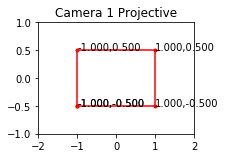

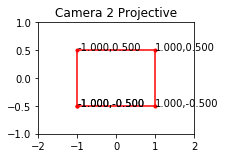

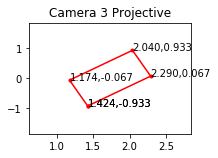

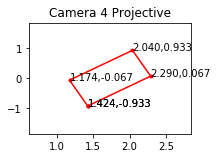

In [381]:
# Explicitly state the matrices for the four cases as described in the problem
# in the four camera functions given below. Make sure that we can see the formula
# (if one exists) being used to fill in the matrices. Feel free to document with
# comments any thing you feel the need to explain.
def camera1():
    ## Your Code Here ##
    P_i = np.eye(3,4) # np.array([[1,0.,0.,0.],[0.,1,0.,0.],[0.,0.,1,0.]])
    P_e = np.eye(4,4)
    return P_i, P_e
def camera2():
    ## Your Code Here ##
    P_i = np.eye(3,4)
    P_e = np.eye(4,4)


    return P_i, P_e
def camera3():
    ## Your Code Here ##
    P_i = np.eye(3,4)
    rotz = np.array([[np.cos(np.pi/6), -np.sin(np.pi/6), 0, 0],\
                     [np.sin(np.pi/6), np.cos(np.pi/6) , 0, 0],\
                     [0              , 0               , 1, 0],\
                     [0              , 0               , 0, 1]])
    roty = np.array([[np.cos(np.pi/3) , 0, np.sin(np.pi/3), 0],\
                     [0               , 1, 0              , 0],\
                     [-np.sin(np.pi/3), 0, np.cos(np.pi/3), 0],\
                     [0               , 0, 0              , 1]])
    P_e = np.dot(roty, rotz)
    P_e[:,3] += [0, 0, 1, 0]
   
    return P_i, P_e
def camera4():
    ## Your Code Here ##
    P_i = np.eye(3,4)
    rotz = np.array([[np.cos(np.pi/6), -np.sin(np.pi/6), 0, 0],\
                     [np.sin(np.pi/6), np.cos(np.pi/6) , 0, 0],\
                     [0              , 0               , 1, 0],\
                     [0              , 0               , 0, 1]])
    roty = np.array([[np.cos(np.pi/3) , 0, np.sin(np.pi/3), 0],\
                     [0               , 1, 0              , 0],\
                     [-np.sin(np.pi/3), 0, np.cos(np.pi/3), 0],\
                     [0               , 0, 0              , 1]])
    P_e = np.dot(roty, rotz)
    P_e[:,3] += [0, 0, 13, 0]
    return P_i, P_e


# Use the following code to display your outputs
# You are free to change the axis parameters to better
# display your quadrilateral but do not remove any annotations
def plot_points(points, title='', style='.-r', axis=[]):
    
    inds = list(range(points.shape[1]))+[0]
    plt.plot(points[0,inds], points[1,inds],style)
    for i in range(len(points[0,inds])):
        plt.annotate(str("{0:.3f}".format(points[0,inds][i]))+","+str("{0:.3f}".format(points[1,inds][i])),(points[0,inds][i], points[1,inds][i]))
    if title:
        plt.title(title)
    if axis:
        plt.axis(axis)
    plt.tight_layout()
    
    
def main():
    point1 = np.array([[-1,-.5,2]]).T
    point2 = np.array([[1,-.5,2]]).T
    point3 = np.array([[1,.5,2]]).T
    point4 = np.array([[-1,.5,2]]).T
    points = np.hstack((point1,point2,point3,point4))
    for i, camera in enumerate([camera1,camera2,camera3,camera4]):
        P_int_proj, P_ext = camera()
        ax1 = plt.subplot(2, 2, i+1)
        plot_points(project_points(P_int_proj, P_ext, points), title='Camera %d Projective'%(i+1))#, axis=[-0.6,2.5,-0.75,0.75])
        ax1.margins(0.5)
        plt.show()
    
main()